In [1]:
import numpy as np
import os

import copy

In [2]:
from spectrum_family_utilities import *

Filtering relevant files based on linked mibig gnps file

In [3]:
gnps_test_dataset_spectrum_dir = "G:\\Dev\\Data\\GNPS For Family Test Q3"
linked_gnps_path = "G:\\Dev\\Data\\Linked GNPS Fingerprints.txt"
linked_mibig_gnps_path = "G:\\Dev\\Data\\mibig_gnps_links_q3_loose.csv"

#input
final_data_path = "G:\\Dev\\Data\\For Family Q3\\GNPS Python Master\\Final Data.txt"
final_fingerprints_data_path = "G:\\Dev\\Data\\For Family Q3\\GNPS Python Master\\Final Fingerprints.txt"
mibig_family_path = "G:\\Dev\\Data\\mibig_family\\gene_family.txt"
gnps_datapath = "G:\\Dev\\Data\\Fingerprint Bitmaps 2\\Mega big GNPS Final Fingerprints.txt"
mibig_datapath = "G:\\Dev\\Data\\Fingerprint Bitmaps 2\\mibig_unique_smiles.txt"

# output
filtered_final_data_path = "G:\\Dev\\Data\\For Family Test Q3\\GNPS Python Master\\Final Data.txt"
filtered_final_fingerprints_data_path = "G:\\Dev\\Data\\For Family Test Q3\\GNPS Python Master\\Final Fingerprints.txt"
gnps_family_path = "G:\\Dev\\Data\\gnps_family.txt"
filtered_mibig_path = "G:\\Dev\\Data\\Filtered Mibig GNPS Links\\Filtered Mibig Fingerprints.txt"
filtered_gnps_path = "G:\\Dev\\Data\\Filtered Mibig GNPS Links\\Filtered GNPS Fingerprints.txt"

filter_gnps_data(gnps_datapath, linked_mibig_gnps_path, filtered_gnps_path)
filter_mibig_data(mibig_datapath, linked_mibig_gnps_path, filtered_mibig_path)

generate_linked_gnps_fingerprints(gnps_datapath, linked_mibig_gnps_path, linked_gnps_path)
get_linked_gnps_data(final_data_path, linked_gnps_path, filtered_final_data_path)
get_linked_gnps_data(final_fingerprints_data_path, linked_gnps_path, filtered_final_fingerprints_data_path)

filter_gnps_dir(gnps_test_dataset_spectrum_dir, linked_gnps_path)
print("Done")

Done


Set up variables for constants such as absolute datapaths and the desired valdiation fraction split.

In [4]:
#gnps
datapath = "G:\\Dev\\Data\\For Family\\GNPS Python Master\\Final Data.txt"
fingerprints_path = "G:\\Dev\\Data\\For Family\\GNPS Python Master\\Final Fingerprints.txt"
fingerprints_names_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Fingerprint Legend.txt"

#gnps for family
gnps_for_family_datapath = "G:\\Dev\\Data\\For Family Q3\\GNPS Python Master\\Final Data.txt"
fingerprints_for_family_gnps_path = "G:\\Dev\\Data\\For Family Q3\\GNPS Python Master\\Final Fingerprints.txt"

#mibig
mibig_fingerprints_path = "G:\\Dev\\Data\\Fingerprint Bitmaps 2\\mibig_unique_smiles.txt"
mibig_families_path = "G:\\Dev\\Data\\Final Families.txt"
mibig_filtered_fingerprints_path = "G:\\Dev\\Data\\Filtered Mibig GNPS Links\\Filtered Mibig Fingerprints.tsv"
mibig_filtered_families_path = "G:\\Dev\\Data\\mibig_family.txt"

#npatlas
npatlas_smiles_fingerprints_path = "G:\\Dev\\Data\\Fingerprint Bitmaps 2\\NPAtlas_DB_last_version_filtered.txt"
npatlas_final_families_path = "G:\\Dev\\Data\\NPAtlas_Final_Families.txt"

#test
test_datapath = "G:\\Dev\\Data\\For Family Test Q3\\GNPS Python Master\\Final Data.txt"
test_fingerprint_path = "G:\\Dev\\Data\\For Family Test Q3\\GNPS Python Master\\Final Fingerprints.txt"

linked_fingerprints_path = "G:\\Dev\\Data\\Linked GNPS Fingerprints.tsv"
families_names_path = "G:\\Dev\\Data\\Family Legend.txt"

num_samples = 5770
num_smiles_families_samples = 1368
val_fraction = 0.1

Import methods from ultilities

In [5]:
from nn_evaluation_interface import plot_loss, compute_auc, evaluate, compute_predicted_family_proportion
from nn_files_load_interface import *
from nn_interface import simplified_fingerprint_model, simplified_family_model
from nn_training_splits_interface import train_diff_splits

C:\Users\CherWei\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Load the data to variables

In [6]:
spectra = load_master_file(path=datapath)
fingerprints = load_fingerprints_master(path=fingerprints_path)

gnps_spectra = load_master_file(path=gnps_for_family_datapath)
gnps_fingerprints = load_fingerprints_master(path=fingerprints_for_family_gnps_path, number_of_rows=1)

mibig_fingerprints = load_fingerprints_master(path=mibig_fingerprints_path)
mibig_families = load_families_master(path=mibig_families_path)
mibig_filtered_fingerprints = load_fingerprints_master(path=mibig_filtered_fingerprints_path, number_of_rows=1)
mibig_filtered_families = load_families_master(path=mibig_filtered_families_path)

fingerprint_names = load_fingerprint_legend(path=fingerprints_names_path)
family_names = load_family_legend(path=families_names_path)

test_spectra = load_master_file(path=test_datapath)
test_fingerprint = load_fingerprints_master(path=test_fingerprint_path)

get_gnps_families(mibig_family_path, family_names, linked_mibig_gnps_path, gnps_datapath, gnps_family_path)

print("Done")

{'CCMSLIB00000072234': {'BGC0000259', 'BGC0000260', 'BGC0000258', 'BGC0000257'}, 'CCMSLIB00000531481': {'BGC0001565', 'BGC0000334'}, 'CCMSLIB00000081147': {'BGC0000067', 'BGC0000068', 'BGC0000066'}, 'CCMSLIB00000070270': {'BGC0000478', 'BGC0000482'}, 'CCMSLIB00000070271': {'BGC0000478', 'BGC0000482'}, 'CCMSLIB00000427303': {'BGC0001034'}, 'CCMSLIB00000478586': {'BGC0001104', 'BGC0001025'}, 'CCMSLIB00000478595': {'BGC0001104', 'BGC0001025'}, 'CCMSLIB00000081287': {'BGC0000100', 'BGC0001670'}, 'CCMSLIB00000081288': {'BGC0000100', 'BGC0001670'}, 'CCMSLIB00000075305': {'BGC0000055', 'BGC0000054'}, 'CCMSLIB00000075306': {'BGC0000055', 'BGC0000054'}, 'CCMSLIB00000006284': {'BGC0000055', 'BGC0000054'}, 'CCMSLIB00000006285': {'BGC0000055', 'BGC0000054'}, 'CCMSLIB00000006286': {'BGC0000055', 'BGC0000054'}, 'CCMSLIB00000006287': {'BGC0000055', 'BGC0000054'}, 'CCMSLIB00000006288': {'BGC0000055', 'BGC0000054'}, 'CCMSLIB00000006289': {'BGC0000055', 'BGC0000054'}, 'CCMSLIB00000006290': {'BGC0000055'

Alkaloid,14
NRP,63
Terpene,7
RiPP,12
Nucleoside,0
Saccharide,10
Polyketide,91
Other,23
Done


The training/evaluation process

C:\Dev\nnpredict\Code\Python\nn_interface.py:117: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  auto_model = Model(input=input_layer, output=out_layer)


Train on 5884 samples, validate on 654 samples
Epoch 1/100
5884/5884 [==============================] - 8s 1ms/step - loss: 0.5015 - val_loss: 0.3027
Epoch 2/100
5884/5884 [==============================] - 5s 783us/step - loss: 0.1756 - val_loss: 0.1612
Epoch 3/100
5884/5884 [==============================] - 5s 774us/step - loss: 0.1226 - val_loss: 0.1348
Epoch 4/100
5884/5884 [==============================] - 5s 870us/step - loss: 0.1121 - val_loss: 0.1245
Epoch 5/100
5884/5884 [==============================] - 6s 978us/step - loss: 0.1079 - val_loss: 0.1189
Epoch 6/100
5884/5884 [==============================] - 6s 982us/step - loss: 0.1055 - val_loss: 0.1154
Epoch 7/100
5884/5884 [==============================] - 5s 913us/step - loss: 0.1039 - val_loss: 0.1129
Epoch 8/100
5884/5884 [==============================] - 6s 1ms/step - loss: 0.1027 - val_loss: 0.1110
Epoch 9/100
5884/5884 [==============================] - 7s 1ms/step - loss: 0.1017 - val_loss: 0.1095
Epoch 10/100
5

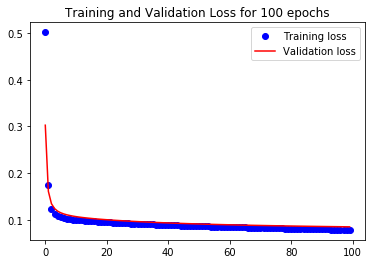

Done


In [7]:
# Training network 1 (exclude links)
epochs = 100
x_train_spectra = np.log(gnps_spectra+1)
x_train_fingerprints = gnps_fingerprints.values
x_test_spectra = np.log(test_spectra+1)

enc1 = simplified_fingerprint_model(x_train_spectra, x_train_fingerprints, epochs=epochs)

actual = test_fingerprint.values
predicted = enc1.predict(x_test_spectra)

n1_stats, n1_perm_scores = compute_auc(320, actual, predicted)

C:\Dev\nnpredict\Code\Python\nn_interface.py:157: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  auto_model = Model(input=input_layer, output=out_layer)


Train on 1165 samples, validate on 130 samples
Epoch 1/100
1165/1165 [==============================] - 3s 3ms/step - loss: 0.5217 - val_loss: 0.3917
Epoch 2/100
1165/1165 [==============================] - 1s 1ms/step - loss: 0.3654 - val_loss: 0.3304
Epoch 3/100
1165/1165 [==============================] - 1s 842us/step - loss: 0.3351 - val_loss: 0.3148
Epoch 4/100
1165/1165 [==============================] - 1s 1ms/step - loss: 0.3224 - val_loss: 0.3068
Epoch 5/100
1165/1165 [==============================] - 1s 1ms/step - loss: 0.3131 - val_loss: 0.3007
Epoch 6/100
1165/1165 [==============================] - ETA: 0s - loss: 0.305 - 1s 1ms/step - loss: 0.3052 - val_loss: 0.2955
Epoch 7/100
1165/1165 [==============================] - 1s 1ms/step - loss: 0.2982 - val_loss: 0.2909
Epoch 8/100
1165/1165 [==============================] - 1s 1ms/step - loss: 0.2920 - val_loss: 0.2868
Epoch 9/100
1165/1165 [==============================] - 2s 1ms/step - loss: 0.2864 - val_loss: 0.2830


1165/1165 [==============================] - 1s 1ms/step - loss: 0.1690 - val_loss: 0.2072
Epoch 78/100
1165/1165 [==============================] - 1s 1ms/step - loss: 0.1684 - val_loss: 0.2071
Epoch 79/100
1165/1165 [==============================] - 1s 1ms/step - loss: 0.1677 - val_loss: 0.2070
Epoch 80/100
1165/1165 [==============================] - 1s 802us/step - loss: 0.1670 - val_loss: 0.2068
Epoch 81/100
1165/1165 [==============================] - 1s 1ms/step - loss: 0.1664 - val_loss: 0.2067
Epoch 82/100
1165/1165 [==============================] - 2s 2ms/step - loss: 0.1658 - val_loss: 0.2066
Epoch 83/100
1165/1165 [==============================] - 3s 2ms/step - loss: 0.1651 - val_loss: 0.2065
Epoch 84/100
1165/1165 [==============================] - 2s 2ms/step - loss: 0.1645 - val_loss: 0.2065
Epoch 85/100
1165/1165 [==============================] - 2s 2ms/step - loss: 0.1639 - val_loss: 0.2064
Epoch 86/100
1165/1165 [==============================] - 2s 1ms/step - los

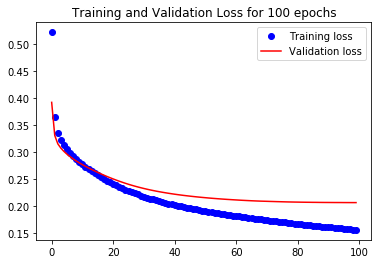

In [8]:
# Training network 2 (exclude links)
epochs = 100
x_train_fingerprints = mibig_filtered_fingerprints
x_train_families = mibig_filtered_families

enc2 = simplified_family_model(x_train_fingerprints.values, x_train_families.values, epochs=epochs)

Compute the families AUC in the fingerprint - family network by using predicted fingerprint

In [9]:
# using linked mibig-gnps as test set
x_train_spectra = load_master_file(path=test_datapath)
predicted = enc1.predict(x_train_spectra)


gnps_families_path = "G:\\Dev\\Data\\gnps_family.txt"
x_train_families = load_families_master(gnps_families_path)
x_train_fingerprints = load_fingerprints_master(test_fingerprint_path, number_of_rows=1)

actual = x_train_families.values
predicted = enc2.predict(predicted) # using predicted fingerprints
exp_stats, exp_perm_scores = compute_auc(8, actual, predicted)

print(exp_stats)
print()
print(exp_perm_scores)
print()

Done
[(0, 14, 0.80889058,   0. ) (1, 63, 0.58593125,   2.8)
 (2,  7, 0.59267399,  19.2) (3, 12, 0.42017544,  83. )
 (4,  0, 0.        , 100. ) (5, 10, 0.63541667,   7.4)
 (6, 91, 0.5996436 ,   0.6) (7, 23, 0.57128977,  17.4)]

[[0.56117021 0.43731003 0.45706687 ... 0.53704407 0.5174772  0.54673252]
 [0.55726847 0.52963344 0.52609341 ... 0.53557154 0.5425374  0.53831221]
 [0.33479853 0.31282051 0.50842491 ... 0.47912088 0.58901099 0.50989011]
 ...
 [0.53020833 0.50833333 0.53072917 ... 0.62447917 0.59114583 0.62239583]
 [0.54588655 0.54291654 0.45213345 ... 0.44500545 0.46431046 0.52668053]
 [0.46295846 0.49453486 0.52732572 ... 0.4870051  0.57687637 0.55210104]]



In [10]:
compute_predicted_family_proportion(gnps_families_path, family_names, x_train_families.index, predicted)

{'Alkaloid': 14, 'NRP': 63, 'Terpene': 7, 'RiPP': 12, 'Nucleoside': 0, 'Saccharide': 10, 'Polyketide': 91, 'Other': 23}
Family, proportion guessed correctly, proportion missed
Alkaloid, 28.57142857142857, 3.8834951456310676
NRP, 15.873015873015872, 11.464968152866243
Terpene, 0.0, 2.3474178403755865
RiPP, 0.0, 0.0
Nucleoside no sample
Saccharide, 0.0, 0.0
Polyketide, 73.62637362637363, 63.565891472868216
Other, 13.043478260869565, 2.5380710659898478


Compute the families AUC in the fingerprint - family network by using true fingerprints

In [11]:
predicted = enc2.predict(x_train_fingerprints.values) # using true fingerprints
exp_stats, exp_perm_scores = compute_auc(8, actual, predicted)

print(exp_stats)
print()
print(exp_perm_scores)
print()

Done
[(0, 14, 0.94946809,   0. ) (1, 63, 0.73758136,   0. )
 (2,  7, 0.8014652 ,   0.8) (3, 12, 0.91535088,   0. )
 (4,  0, 0.        , 100. ) (5, 10, 0.9234375 ,   0. )
 (6, 91, 0.94911395,   0. ) (7, 23, 0.63760019,   1.4)]

[[0.54160334 0.4006459  0.49506079 ... 0.52754559 0.48822188 0.44490881]
 [0.44747059 0.54128126 0.54282288 ... 0.51073427 0.54584904 0.46779719]
 [0.54615385 0.49377289 0.63956044 ... 0.47838828 0.42564103 0.47179487]
 ...
 [0.60859375 0.48515625 0.46197917 ... 0.57708333 0.446875   0.47109375]
 [0.45208395 0.50648451 0.53395703 ... 0.52757153 0.53262053 0.50985051]
 [0.61173184 0.50315764 0.52404664 ... 0.47303862 0.50109303 0.48664076]]



In [12]:
compute_predicted_family_proportion(gnps_families_path, family_names, x_train_families.index, predicted)

{'Alkaloid': 14, 'NRP': 63, 'Terpene': 7, 'RiPP': 12, 'Nucleoside': 0, 'Saccharide': 10, 'Polyketide': 91, 'Other': 23}
Family, proportion guessed correctly, proportion missed
Alkaloid, 14.285714285714285, 0.48543689320388345
NRP, 36.507936507936506, 11.464968152866243
Terpene, 28.57142857142857, 3.755868544600939
RiPP, 25.0, 0.0
Nucleoside no sample
Saccharide, 40.0, 0.0
Polyketide, 94.5054945054945, 20.930232558139537
Other, 39.130434782608695, 9.644670050761421


Use a bigger test dataset (the whole MIBiG - 1813 samples)

In [13]:
# using mibig all as test dataset
x_train_fingerprints = mibig_fingerprints
x_train_families = mibig_families

actual = x_train_families.values
predicted = enc2.predict(x_train_fingerprints.values) # using true fingerprints
exp_stats, exp_perm_scores = compute_auc(8, actual, predicted)

print(exp_stats)
print()
print(exp_perm_scores)
print()

Done
[(0,  90, 0.96615901,  0. ) (1, 505, 0.91012697,  0. )
 (2, 131, 0.97419894,  0. ) (3,  72, 0.98460101,  0. )
 (4,   1, 0.1659751 , 83.2) (5, 103, 0.97228964,  0. )
 (6, 722, 0.94093801,  0. ) (7, 189, 0.90389549,  0. )]

[[0.58241218 0.44507083 0.48048391 ... 0.49814542 0.46986817 0.48865144]
 [0.50999769 0.5007967  0.4884583  ... 0.50290934 0.50095647 0.49637594]
 [0.53619864 0.49290877 0.46955556 ... 0.50543806 0.55201397 0.51580953]
 ...
 [0.55795264 0.51569363 0.51985813 ... 0.5067795  0.52570937 0.47132888]
 [0.50354189 0.5159681  0.487015   ... 0.48618111 0.51134397 0.50666253]
 [0.51140847 0.50151202 0.51990226 ... 0.49513589 0.51362707 0.47247458]]



In [14]:
compute_predicted_family_proportion(mibig_families_path, family_names, x_train_families.index, predicted)

{'Alkaloid': 90, 'NRP': 505, 'Terpene': 131, 'RiPP': 72, 'Nucleoside': 1, 'Saccharide': 103, 'Polyketide': 722, 'Other': 189}
Family, proportion guessed correctly, proportion missed
Alkaloid, 32.22222222222222, 0.3482298316889147
NRP, 62.97029702970297, 5.81039755351682
Terpene, 73.2824427480916, 1.1296076099881094
RiPP, 56.94444444444444, 0.402067777139575
Nucleoside, 0.0, 0.0
Saccharide, 18.446601941747574, 0.11695906432748539
Polyketide, 84.07202216066482, 8.615948670944087
Other, 49.735449735449734, 2.401477832512315


Get common fingerprint for each family

In [15]:
family_common_fingerprint_path = "G:\\Dev\\Data\\family_common_substructures.txt"
family_substructure_auc_path = "G:\\Dev\\Data\\family_substructure_auc.txt"
family_substructure_auc = {}
n1_stats = list(n1_stats)

with open(family_common_fingerprint_path, 'r') as f:
    for line in f:
        family, bit_name, occurrence, occurence_other, diff = line.split("  ")
        if family not in family_substructure_auc:
            family_substructure_auc[family] = {}
        family_substructure_auc[family][bit_name] = n1_stats[fingerprint_names.index(bit_name)][2]

with open(family_substructure_auc_path, 'w') as f:
    for key, details in family_substructure_auc.items():
        for substructure, auc in details.items():
            f.write(key + "," + substructure + "," + str(round(auc,2)) + "\n")

print("Done")

Done


Classification accuracy saved into .csv report in format of id, families... , true label

In [ ]:
mibig_links_path = "G:\\Dev\\Data\\mibig_gnps_links_q3_loose.csv"
mibig_family_path = "G:\\Dev\\Data\\mibig_family\\gene_family.txt"
mibig_gnps_df = pd.read_csv(mibig_links_path, sep=",")

mibig_gnps_dict = {}
mibig_families = {}
mibig_families_count = {}

for index, row in mibig_gnps_df.iterrows():
    if row["gnps_id"] not in mibig_gnps_dict:
        mibig_gnps_dict[row["gnps_id"]] = set()
    mibig_gnps_dict[row["gnps_id"]].add(row["#mibig_id"])

with open(mibig_family_path, 'r') as f:
    for line in f:
        mibig_id, family = line.split("  ")
        if mibig_id not in mibig_families:
            mibig_families[mibig_id] = []
        mibig_families[mibig_id].append(family[:-1])
        
probability_report_path = "G:\\Dev\\Data\\gnps_prediction_report.csv"
families = ["Alkaloid", "NRP", "Terpene", "RiPP", "Nucleoside", "Saccharide", "Polyketide", "Other"]
true_family_counter = {}
family_correct_counter = {}

for family in families:
    true_family_counter[family] = 0
    family_correct_counter[family] = 0

with open(probability_report_path, 'w') as f:
    f.write("#mibig_id,gnps_id,Alkaloid,NRP,Terpene,RiPP,Nucleoside,Saccharide,Polyketide,Other,True Label\n")

with open(probability_report_path, 'a') as f:    
    for index, probabilities in enumerate(predicted):
        temp = copy.deepcopy(probabilities).tolist()
        gnps_id = x_train_fingerprints.index[index]
        prob_string = ",".join(map(str, probabilities))
        for mibig_id in mibig_gnps_dict[gnps_id]:
            true_labels = []
            max_indexes = []
            for true_family in mibig_families[mibig_id]:
                true_labels.append(true_family)
                max_index = temp.index(max(temp))
                max_indexes.append(max_index)
                temp.remove(temp[max_index])
                true_family_counter[true_family] += 1
                f.write(mibig_id + "," + gnps_id + "," + prob_string + "," + true_family + "\n")
            for index in max_indexes:
                if families[index] in true_labels:
                    family_correct_counter[families[index]] += 1
    
prediction_comparison_report_path = "G:\\Dev\\Data\\prediction_comparison_report.txt"
with open(prediction_comparison_report_path, 'w') as f:
    f.write("family,matched,actual,proportion\n")

with open(prediction_comparison_report_path, 'a') as f:
    for family in family_correct_counter:
        matched = family_correct_counter[family]
        actual = true_family_counter[family]
        proportion = 0
        if actual != 0:
            proportion = matched / actual
        f.write(family + "," + str(matched) + "," + str(actual) + "," + str(proportion*100) + "\n")
    
print("Done")

Save model into .h5 format

In [ ]:
filepath = "G:\\Dev\\Data\\saved_spectrum_fingerprint_non_binary_model.h5"
enc1.save(filepath)

filepath = "G:\\Dev\\Data\\saved_fingerprint_families_non_binary_model.h5"
enc2.save(filepath)